
# EfficientNet-B3 with Early Stopping for EuroSAT Classification

This notebook trains **EfficientNet-B3** on the **EuroSAT dataset** with:
- **25 epochs planned** (but stops early if no improvement)
- **Early stopping** (patience = 5)
- **Best model checkpoint saving**
- **Training/Validation accuracy & loss plots**
- **Confusion matrix and classification report**


In [1]:
# 📦 Install required libraries
!pip install torch torchvision torchaudio matplotlib scikit-learn seaborn --quiet

In [2]:
# 📚 Imports
import torch, torch.nn as nn, torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt, numpy as np, os, copy
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda



## 1️⃣ Dataset Loading & Preparation

We use **EuroSAT (RGB)** dataset: 27,000 satellite images in 10 classes.

Steps:
- Download dataset (if not present)
- Apply augmentations & normalization (resize to 224×224 for memory efficiency)
- Create 80/20 train/test split


In [3]:
dataset_root = './EuroSAT_RGB'
if not os.path.exists(dataset_root):
    !wget https://zenodo.org/record/7711810/files/EuroSAT_RGB.zip -O EuroSAT_RGB.zip
    !unzip -q EuroSAT_RGB.zip -d ./

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=dataset_root, transform=transform)
num_classes = len(dataset.classes)
print(f"Loaded {len(dataset)} images across {num_classes} classes: {dataset.classes}")


--2025-09-12 16:16:01--  https://zenodo.org/record/7711810/files/EuroSAT_RGB.zip
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.48.194, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/7711810/files/EuroSAT_RGB.zip [following]
--2025-09-12 16:16:02--  https://zenodo.org/records/7711810/files/EuroSAT_RGB.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 94658721 (90M) [application/octet-stream]
Saving to: ‘EuroSAT_RGB.zip’

EuroSAT_RGB.zip     100%[===================>]  90.27M  18.9MB/s    in 46s     

2025-09-12 16:16:48 (1.97 MB/s) - ‘EuroSAT_RGB.zip’ saved [94658721/94658721]

Loaded 27000 images across 10 classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [4]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Training samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")


Training samples: 21600, Test samples: 5400



## 2️⃣ Model: EfficientNet-B3

We load a **pretrained EfficientNet-B3** (ImageNet weights) and replace its classifier head to match the 10 EuroSAT classes.

We also define:
- **CrossEntropyLoss with label smoothing**
- **Adam optimizer with weight decay**
- **Mixed precision training** for speed and memory efficiency


In [5]:
model = models.efficientnet_b3(weights='IMAGENET1K_V1')
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler()


Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth


100%|██████████| 47.2M/47.2M [00:00<00:00, 185MB/s]
/tmp/ipython-input-3410950327.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



## 3️⃣ Training Loop with Early Stopping

- **Epochs planned:** 12  
- **Patience:** 5 → if no validation improvement for 5 consecutive epochs, training stops early.
- **Best checkpoint:** model state is saved whenever validation accuracy improves.

We also log training/validation losses for plotting later.


In [8]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

epochs = 12
patience = 5
patience_counter = 0
best_acc = 0.0
best_w = copy.deepcopy(model.state_dict())

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

def evaluate(loader):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            with torch.cuda.amp.autocast():
                logits = model(x)
                loss = criterion(logits, y)
            running_loss += loss.item()
            preds = logits.argmax(1)
            total += y.size(0)
            correct += (preds == y).sum().item()
    return running_loss/len(loader), correct/total

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast():
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        total += y.size(0)
        correct += (logits.argmax(1) == y).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    val_loss, val_acc = evaluate(test_loader)

    scheduler.step(val_loss)
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} Acc: {train_acc:.3f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.3f}")

    if val_acc > best_acc:
        best_acc = val_acc
        best_w = copy.deepcopy(model.state_dict())
        patience_counter = 0
        os.makedirs('./saved_models', exist_ok=True)
        torch.save({'model_state_dict': best_w, 'classes': dataset.classes},
                   './saved_models/efficientnet_b3_eurosat_best.pth')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered!")
        break

    torch.cuda.empty_cache()

model.load_state_dict(best_w)
print(f"✅ Best validation accuracy: {best_acc:.3f}")


/tmp/ipython-input-1231971931.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-1231971931.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/12 | Train Loss: 0.8505 Acc: 0.877 | Val Loss: 0.5834 Acc: 0.970
Epoch 2/12 | Train Loss: 0.6173 Acc: 0.958 | Val Loss: 0.5631 Acc: 0.976
Epoch 3/12 | Train Loss: 0.5835 Acc: 0.971 | Val Loss: 0.5542 Acc: 0.980
Epoch 4/12 | Train Loss: 0.5694 Acc: 0.975 | Val Loss: 0.5524 Acc: 0.980
Epoch 5/12 | Train Loss: 0.5587 Acc: 0.980 | Val Loss: 0.5458 Acc: 0.982
Epoch 6/12 | Train Loss: 0.5504 Acc: 0.984 | Val Loss: 0.5410 Acc: 0.984
Epoch 7/12 | Train Loss: 0.5445 Acc: 0.985 | Val Loss: 0.5399 Acc: 0.985
Epoch 8/12 | Train Loss: 0.5383 Acc: 0.988 | Val Loss: 0.5456 Acc: 0.982
Epoch 9/12 | Train Loss: 0.5385 Acc: 0.987 | Val Loss: 0.5385 Acc: 0.986
Epoch 10/12 | Train Loss: 0.5301 Acc: 0.991 | Val Loss: 0.5430 Acc: 0.983
Epoch 11/12 | Train Loss: 0.5314 Acc: 0.990 | Val Loss: 0.5399 Acc: 0.986
Epoch 12/12 | Train Loss: 0.5322 Acc: 0.990 | Val Loss: 0.5450 Acc: 0.983
✅ Best validation accuracy: 0.986



## 4️⃣ Training Curves

Let's visualize training vs validation loss and accuracy.


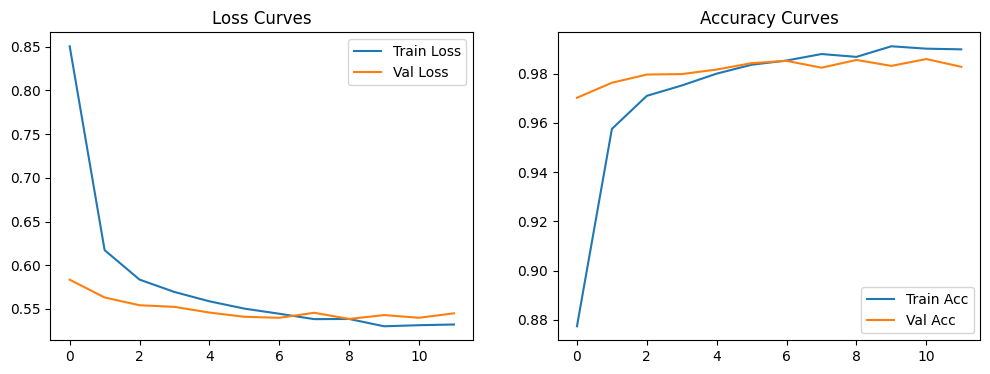

In [9]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label='Train Loss')
plt.plot(history["val_loss"], label='Val Loss')
plt.legend(); plt.title("Loss Curves")

plt.subplot(1,2,2)
plt.plot(history["train_acc"], label='Train Acc')
plt.plot(history["val_acc"], label='Val Acc')
plt.legend(); plt.title("Accuracy Curves")
plt.show()



## 5️⃣ Evaluation

We generate classification report and confusion matrix on test set.


/tmp/ipython-input-2615751327.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


                      precision    recall  f1-score   support

          AnnualCrop       0.99      0.98      0.98       608
              Forest       0.98      1.00      0.99       593
HerbaceousVegetation       0.97      0.97      0.97       611
             Highway       0.98      0.99      0.99       490
          Industrial       1.00      0.99      1.00       524
             Pasture       0.97      0.95      0.96       430
       PermanentCrop       0.98      0.97      0.98       470
         Residential       1.00      1.00      1.00       568
               River       0.98      0.99      0.99       515
             SeaLake       0.98      1.00      0.99       591

            accuracy                           0.98      5400
           macro avg       0.98      0.98      0.98      5400
        weighted avg       0.98      0.98      0.98      5400



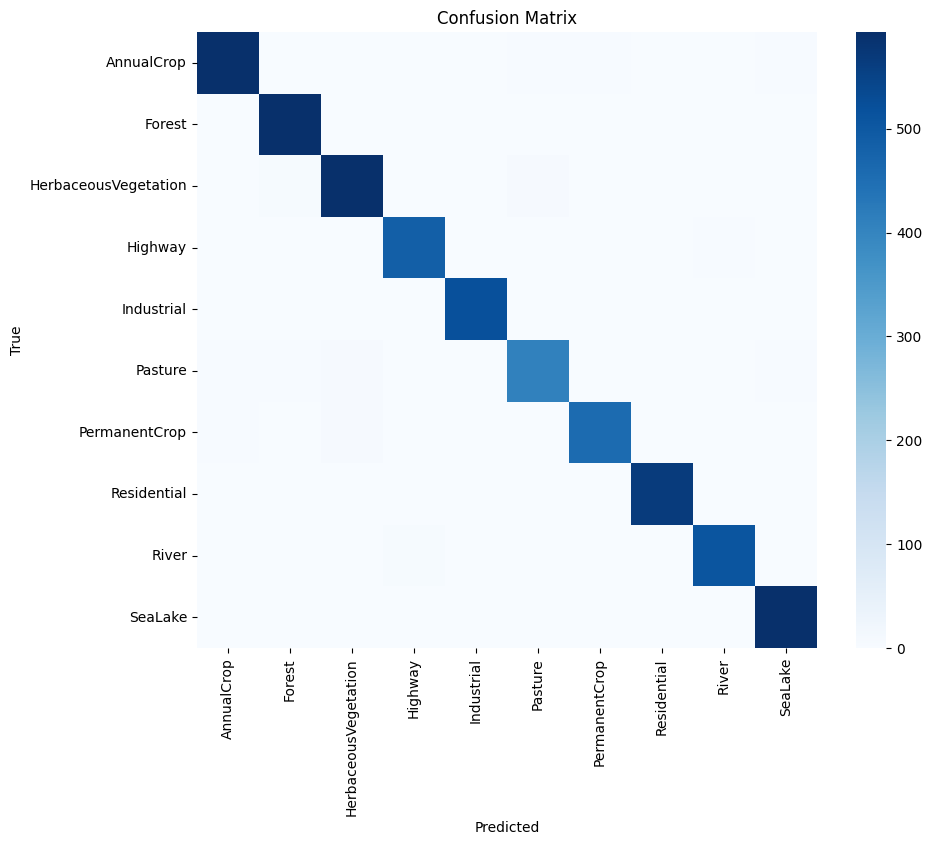

In [10]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        with torch.cuda.amp.autocast():
            outputs = model(images)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=dataset.classes))
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.show()
